# Aim

This notebook contains code to setup training pipelines starting from pre-trained weights of **cell ResUnet (c-ResUnet)** network from [*Morelli, R., Clissa, L. et al., SciRep (2021)*](https://www.nature.com/articles/s41598-021-01929-5).

### Imports
Import libraries and write settings here.

In [1]:
# OS related
import os
import sys
from pathlib import Path

# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30
pd.options.display.float_format = '{:,.4f}'.format

# autoreload extension
%load_ext autoreload
%autoreload 2

# add repo root path to pythonpath
### Note: this assumes custom python modules are accessible in the root path AND notebooks are in a folder inside root, e.g. root/notebooks
sys.path.insert(0, str(Path.cwd().parent))

# Experiment configuration

The following cell collects all the hyperparameters needed for the experiment.

In [2]:
from fastai.vision.all import *
from fluocells.config import REPO_PATH, DATA_PATH, DATA_PATH_g, DATA_PATH_y, DATA_PATH_r, METADATA


# reproducibility
SEED = 17
VAL_PCT = 0.2

# data and augmentation params
BS = 32
CROP_SIZE = 512
RESIZE = 224
MAX_LIGHT = 0.1
ZOOM_DELTA = 0.1  # min_zoom = 1 - ZOOM_DELTA; max_zoom = 1 + ZOOM_DELTA
MAX_ROTATION_ANGLE = 15.0

# model params
N_IN, N_OUT = 16, 2
PRETRAINED = True

# optimizer params
# W_CELL, W_BKGD = 1, 1
LOSS_FUNC, LOSS_NAME = DiceLoss(axis=1, smooth=1e-06, reduction='mean', square_in_union=False), 'Dice'
LR = None
OPT, OPT_NAME = partial(Adam, lr=LR), 'Adam'
MONIT_SCORE, MIN_DELTA, PATIENCE_ES = 'dice', 0, 20 # early stopping
FACTOR, PATIENCE_LR = 1.2, 4 # scheduling learning rate


hyperparameter_defaults = dict(
    # reproducibility
    seed=SEED, val_pct=VAL_PCT,
    # dataloader
    bs=BS,
    crop_size=CROP_SIZE,
    resize=RESIZE,
    batch_size=BS,
    angle=MAX_ROTATION_ANGLE,
    zoom_delta=ZOOM_DELTA,
    max_light=MAX_LIGHT,
    # model
    n_in=N_IN, n_out=N_OUT,
    pretrained=PRETRAINED,
    # optimizer
    loss_func=LOSS_FUNC, loss_name=LOSS_NAME,
    lr=LR,
    opt=OPT, opt_name=OPT_NAME,
    monit_dict={'score': MONIT_SCORE, 'min_delta': MIN_DELTA, 'patience': PATIENCE_ES},
    lr_monit_dict={'factor': FACTOR, 'patience': PATIENCE_LR},
)

cfg = namedtuple('Config', hyperparameter_defaults.keys())(
    **hyperparameter_defaults)

EXP_NAME = f'{LOSS_NAME}'
log_path = REPO_PATH/ 'logs' / EXP_NAME  
log_path.mkdir(exist_ok=True, parents=True)

model_path = f'{REPO_PATH}/models/{EXP_NAME}'

##  Dataloader


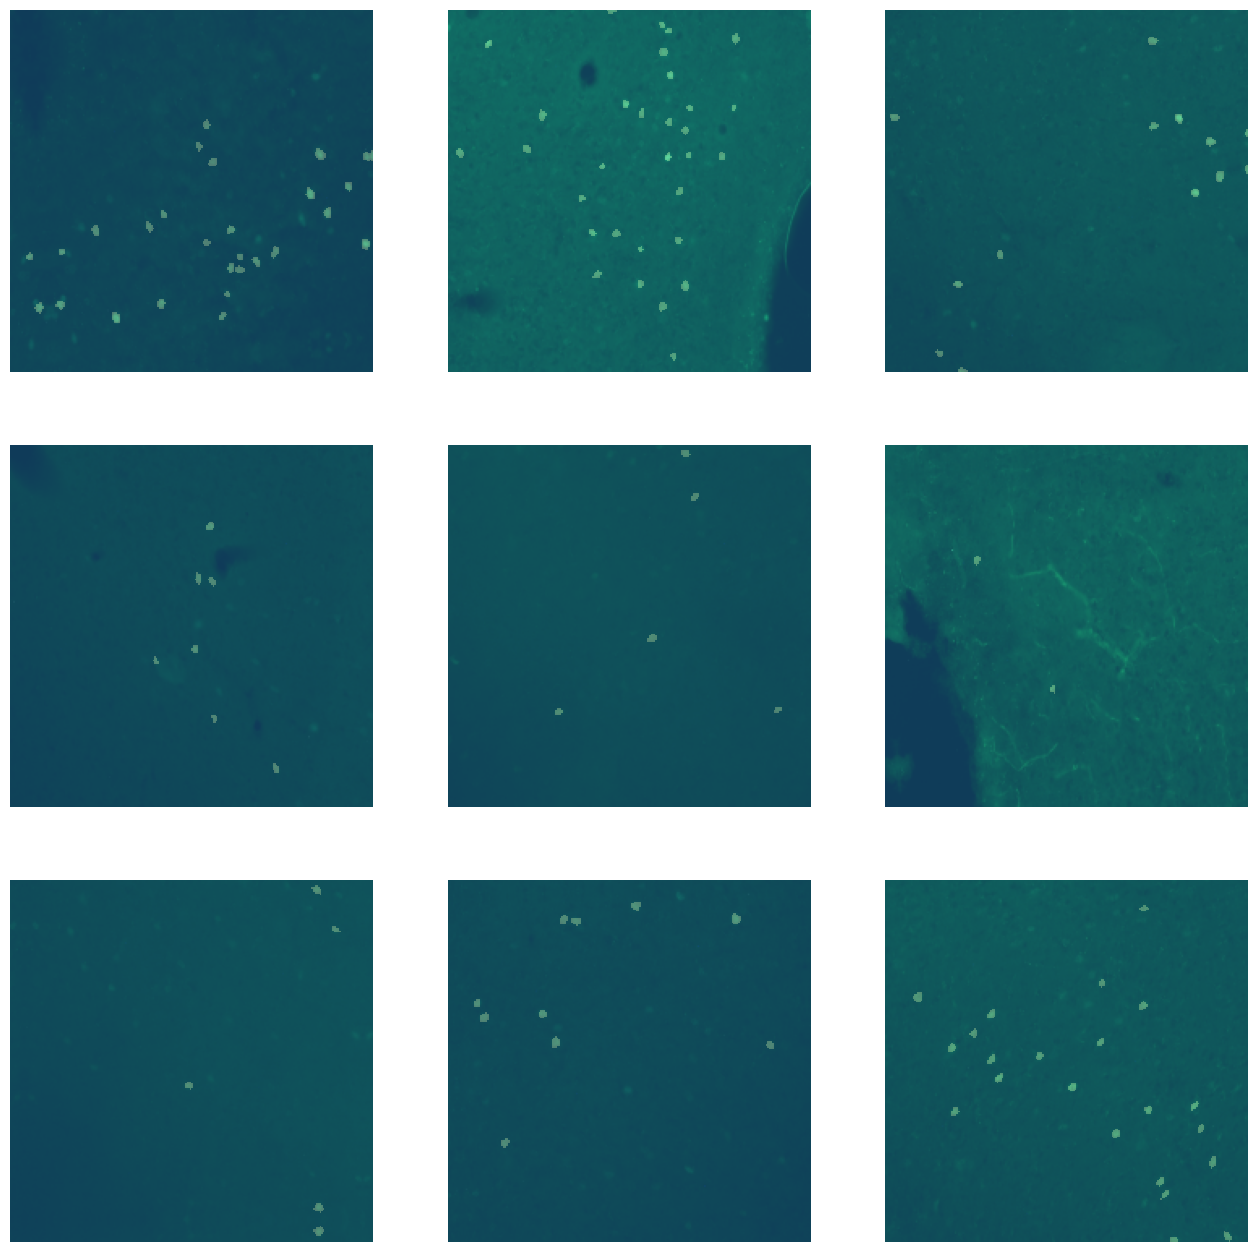

In [3]:
def label_func(p):
    return Path(str(p).replace('images', 'ground_truths/masks'))


trainval_path = DATA_PATH_g / "trainval" / "images" # edit dataset folder here: DATA_PATH_g --> green; DATA_PATH_y --> yellow; DATA_PATH_r --> red 

# read train/valid/test split dataframe
split_df = pd.read_excel(DATA_PATH / f"metadata_{METADATA['current_version']}.xlsx", sheet_name="metadata")
trainval_fnames = [fn for fn in trainval_path.iterdir()]

# augmentation
tfms = [
    IntToFloatTensor(div_mask=255.),  # need masks in [0, 1] format
    RandomCrop(CROP_SIZE),
    *aug_transforms(
        size=RESIZE, # resize
        max_lighting=MAX_LIGHT, p_lighting=0.5, # variazione luminosità
        min_zoom=1-ZOOM_DELTA, max_zoom=1+ZOOM_DELTA, # zoom
        max_warp=0, # distorsione
        max_rotate=MAX_ROTATION_ANGLE # rotazione
    )
]


# splitter
splitter = RandomSplitter(valid_pct=VAL_PCT, seed=SEED)

# dataloader
dls = SegmentationDataLoaders.from_label_func(
    DATA_PATH, fnames=trainval_fnames, label_func=label_func,
    bs=BS,
    splitter=splitter,
    batch_tfms=tfms,
    device='cuda'
)

dls.show_batch(max_n=9, figsize=(16,16))

## Learner

In [7]:
from fluocells.models import cResUnet, c_resunet


torch.set_printoptions(precision=10)

# training from scratch
cresunet = cResUnet(cfg.n_in, cfg.n_out)


# uncomment for loading pre-trained weights
arch = 'c-ResUnet'
# cresunet = c_resunet(arch=arch, n_features_start=cfg.n_in, n_out=cfg.n_out, pretrained=True)

CBS = [CSVLogger]

learn = Learner(dls, model=cresunet, loss_func=cfg.loss_func,
                metrics=[Dice(), JaccardCoeff(), foreground_acc],
                cbs=CBS,
                path=log_path , 
                model_dir=model_path,
                )  

print(
    f'Logs save path: {learn.path}\nModel save path: {learn.path / learn.model_dir}')

learn.summary()

Logs save path: /home/luca/workspace/luca/PycharmProjects/fluocells-scientific-data/logs/Dice
Model save path: /home/luca/workspace/luca/PycharmProjects/fluocells-scientific-data/models/Dice


cResUnet (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 1 x 224 x 224  
Conv2d                                    4          True      
BatchNorm2d                               2          True      
ELU                                                            
____________________________________________________________________________
                     32 x 16 x 224 x 224 
Conv2d                                    160        True      
BatchNorm2d                               32         True      
ELU                                                            
Conv2d                                    2320       True      
____________________________________________________________________________
                     32 x 16 x 112 x 112 
MaxPool2d                                                      
BatchNorm2d                               32         True      
ELU                                  

SuggestedLRs(valley=0.0030199517495930195)

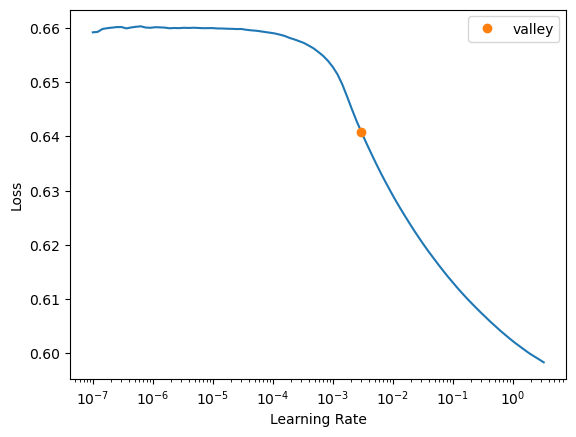

In [8]:
res = learn.lr_find()
res

In [9]:
print("Suggested starting learning rate at:\t", res.valley)

Suggested starting learning rate at:	 0.0030199517495930195


# Training 

In [10]:
cfg._replace(lr=res.valley)
cfg._replace(opt=partial(Adam, lr=cfg.lr))
# write_config(hyperparameter_defaults, log_path / "cfg.pkl")

learn.fit_one_cycle(n_epoch=10, lr_max=res.valley, cbs=CBS)

epoch,train_loss,valid_loss,dice,jaccard_coeff,foreground_acc,time
0,0.656140,0.657230,0.000000,0.000000,0.000000,00:31
1,0.640697,0.652118,0.000950,0.000475,0.000472,00:30
2,0.616123,0.572959,0.000000,0.000000,0.000000,00:32
3,0.602797,0.572959,0.000000,0.000000,0.000000,00:32
4,0.594103,0.572961,0.000000,0.000000,0.000000,00:32
5,0.588133,0.573262,0.001123,0.000562,0.000672,00:32
6,0.583795,0.574660,0.004077,0.002042,0.004344,00:32
7,0.580526,0.574157,0.000000,0.000000,0.000000,00:31
8,0.577951,0.573140,0.000000,0.000000,0.000000,00:32
9,0.576044,0.573071,0.000000,0.000000,0.000000,00:33


    <INSERT COMMENTS HERE>

In [11]:
MONIT_SCORE, MIN_DELTA, PATIENCE_ES = 'dice', 0.005, 20
cfg._replace(monit_dict={'score': MONIT_SCORE, 'min_delta': MIN_DELTA, 'patience': PATIENCE_ES})

CBS = [
    SaveModelCallback(monitor=MONIT_SCORE, min_delta=MIN_DELTA, fname='model',
                      every_epoch=False, at_end=False, with_opt=True, reset_on_fit=False),
    CSVLogger(append=True)
]

learn.fit_one_cycle(n_epoch=10, lr_max=cfg.lr, cbs=CBS)

epoch,train_loss,valid_loss,dice,jaccard_coeff,foreground_acc,time


Better model found at epoch 0 with dice value: 0.0.


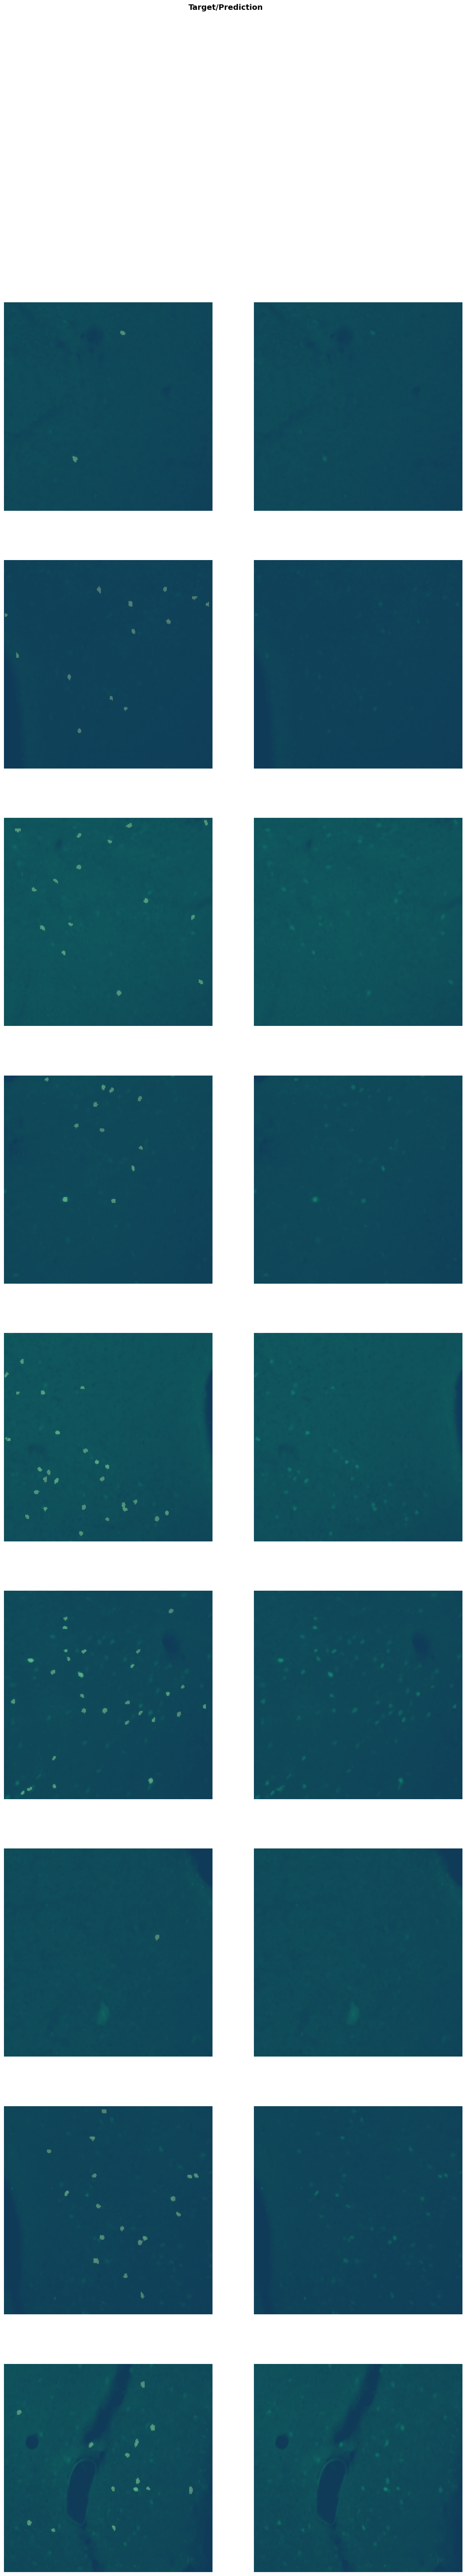

In [12]:
learn.show_results(figsize=(15, 75))

    <INSERT COMMENTS HERE>